In [1]:
# pip install statsmodels


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import acf


In [3]:
def load_data():
    df = pd.read_csv('../data/kzhan176/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [4]:
def process_calgorial_features(df):

    '''
    one hot encoding:
    - masked_bank_num
    - masked_account_type
    - masked_product_code_grouped
    - relationship_balance_new_account
    - oao_flg
    - onus_ind
    - treasury_check_ind
    - heloc_ind
    '''

    # drop unused columns
    cols_to_drop = ['masked_dep_acct_num', 'masked_id', 'channel', 'drawee_avg', 'drawee_max', 'drawee_min', 'RDI_DT', 'RETURN_REASON', 'over_draft_amount']
    df.drop(columns=cols_to_drop, inplace=True)

    # process masked_product_code
    top_n = 8
    top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
    df['masked_product_code_grouped'] = df['masked_product_code'].apply(
        lambda x: f'prod_{x}' if x in top_product_codes else 'Other'
    )
    df.drop(columns='masked_product_code', inplace=True)

    # one_hot_features = ['masked_bank_num', 'masked_account_type', 'masked_product_code_grouped']
    # df = pd.get_dummies(df, columns=one_hot_features)
    
    df['oao_flg'] = (df['oao_flg'] == 'Y').astype(int)


    '''
    ordinal encoding
    - bucket_days_since_open
    - deposit_quarter
    - deposit_dayofweek
    '''

    # fill missing values with -1
    df['bucket_days_since_open'] = df['bucket_days_since_open'].fillna(-1)
    ordinal_mapping = {
    '0-1000': 0,
    '1000-2000': 1,
    '2000-5000': 2,
    '5000+': 3,
    -1: -1   
    }
    
    df['bucket_days_since_open'] = df['bucket_days_since_open'].map(ordinal_mapping)
    print(df['bucket_days_since_open'].unique())

    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
    df['deposit_quarter'] = df['deposit_dt'].dt.quarter.astype(str)  # convert to str for one-hot
    df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek.astype(str)  # convert to str for one-hot
    df.drop(columns='deposit_dt', inplace=True)

    cat_ftrs = ['onus_ind', 'treasury_check_ind', 'heloc_ind',
            'masked_bank_num', 'masked_account_type', 'masked_product_code_grouped', 'relationship_balance_new_account', 'oao_flg', 'deposit_dayofweek', 'deposit_quarter']

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='other')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


    return categorical_transformer, cat_ftrs


def process_continous_features(df):
    # total_deposit_amount
    df['total_deposit_amount'] = df['total_deposit_amount'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # item_amt
    df['item_amt'] = df['item_amt'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # relationship_balance
    df['relationship_balance_new_account'] = (df['relationship_balance'] == -99999999).astype(int)

    df['relationship_balance'] = df['relationship_balance'].replace(-99999999, np.nan)
    median_val = df['relationship_balance'].median()
    df['relationship_balance'] = df['relationship_balance'].fillna(median_val)
    #min_val = df['relationship_balance'].min()
    #shift = 1 - min_val if min_val <= 0 else 0
    #df['relationship_balance'] = np.log1p(df['relationship_balance'] + shift)


    # ratio of total deposit amount and relationship balance
    df['rel_balance_ratio'] = df['total_deposit_amount'] / (df['relationship_balance'] + 1e-3)
    # sign log
    df['rel_balance_signed_log'] = np.sign(df['relationship_balance']) * np.log1p(np.abs(df['relationship_balance']))

    # ratio of max_deposit_amount for 30d and total deposit amount
    df['max_dep_ratio_30d'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1e-3)


    # rdis, max_deposit_amount30d, total_deposit_item_count
    # drawee_sum, drawee_cnt
    num_ftrs = ['drawee_sum', 'drawee_cnt']
    log_num_ftrs = ['rdis', 'max_deposit_amount30d', 'total_deposit_item_count']

    df['rdis'] = df['rdis'].fillna(0)
    df['drawee_sum'] = df['drawee_sum'].fillna(0)
    df['drawee_cnt'] = df['drawee_cnt'].fillna(0)

    numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

    log_numeric_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p, feature_names_out = 'one-to-one')),
        ('scaler', RobustScaler())])
    
    return log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs

'''
helper function for process_prevtran_features
'''
def prevtran_missing_imputation(df, flag="zero"):
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    if flag == "zero":
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        df[prevtran_cols] = imputer.fit_transform(df[prevtran_cols])
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'zero' is supported.")

'''
helper function for process_prevtran_features
'''
def prevtrandate_missing_imputation(df, flag="prevdate"):

    if flag == "prevdate":
        def impute_prevtrandate(row):
            # Find the last available value (starting from 10 to 1)
            for i in reversed(range(10)):
                val = row[prevtrandate_cols[i]]
                if not pd.isna(val):
                    return row.fillna(val)
            return row.fillna(0)

        prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
        df[prevtrandate_cols] = df[prevtrandate_cols].apply(impute_prevtrandate, axis=1)
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'prevdate' is supported.")

'''
Helper function for process_prevtran_features
'''
from statsmodels.tsa.stattools import acf

def compute_acf_lag1(row):
    x = row.values.astype(float)
    return pd.Series([acf(x, nlags=1, fft=False)[1]])

'''
deal with prevtran* and prevtrandate*
'''
def process_prevtran_features(df):

    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]  # keep prevtran1–6
    drop_prevtran_cols = [f'prevtran{i}' for i in range(7, 11)]

    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 7)]  # keep prevtrandate1–6
    drop_prevtrandate_cols = [f'prevtrandate{i}' for i in range(7, 11)]

    # Mean, median, std, min, max, and sum across previous transactions, 
    # preserve absence of behavior in the statistics by computing before imputing
    df['prevtran_mean'] = df[prevtran_cols].mean(axis=1, skipna=True)
    df['prevtran_std'] = df[prevtran_cols].std(axis=1, skipna=True)
    df['prevtran_sum'] = df[prevtran_cols].sum(axis=1, skipna=True)
    df['prevtran_valid_count'] = df[prevtran_cols].notnull().sum(axis=1)

    # prevtrandate summary stats
    df['prevtrandate_mean'] = df[prevtrandate_cols].mean(axis=1, skipna=True)
    df['prevtrandate_std'] = df[prevtrandate_cols].std(axis=1, skipna=True)

    # add an isoutlier column to preserve extreme behavior as a signal
    threshold = df[prevtran_cols].stack().quantile(0.99)
    df['isoutlier_prevtran'] = (df[prevtran_cols].max(axis=1) > threshold).astype(int)

    # impute missing values
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    # if not check_prevtran_imputed:
    #     raise ValueError(f"Imputation incomplete: Some prevtran/prevtrandate values are still missing.")

    # take log of prevtran1–6, since data right-skewed
    df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)

    # prevtran_diff0, prevtran_ratio0
    df['prevtran_diff0'] = df['total_deposit_amount'] - df['prevtran1']
    df['prevtran_ratio0'] = df['total_deposit_amount'] / (df['prevtran1'] + 1e-3)
    
    # prevtran_diff1, prevtran_ratio1
    df['prevtran_diff1'] = df['prevtran1'] - df['prevtran2']
    df['prevtran_ratio1'] = df['prevtran1'] / (df['prevtran2'] + 1e-3)
    
    # timeseries features: acf
    df[['acf_lag1']] = df[keep_prevtran_cols].apply(compute_acf_lag1, axis=1)

    # rolling window features

    # when the amount is filled by 0, rolling window does not make sense, 
    # therefore we fill the rolling mean with 0. (?)
    recent_3 = [f'prevtran{i}' for i in range(1, 4)]
    recent_5 = [f'prevtran{i}' for i in range(1, 6)]

    valid_3 = df[recent_3].ne(0).sum(axis=1)
    valid_5 = df[recent_5].ne(0).sum(axis=1)

    df['rolling_mean_prevtran_3'] = np.where(valid_3 >= 2,
        df[recent_3].replace(0, np.nan).mean(axis=1),
        0
    )
    df['rolling_std_prevtran_3'] = np.where(valid_3 >= 2,
        df[recent_3].replace(0, np.nan).std(axis=1),
        0
    )

    df['rolling_mean_prevtran_5'] = np.where(valid_5 >= 2,
        df[recent_5].replace(0, np.nan).mean(axis=1),
        0
    )
    df['rolling_std_prevtran_5'] = np.where(valid_5 >= 2,
        df[recent_5].replace(0, np.nan).std(axis=1),
        0
    )
    # number of transcations in short gaps
    df['num_trans_in_1d'] = (df['prevtrandate1'] <= 1).astype(int)
    # only keep the most recent few transactions for gap
    df['num_trans_in_5d'] = (df[[f'prevtrandate{i}' for i in range(1, 4)]] <= 5).sum(axis=1)
    df['num_trans_in_10d'] = (df[[f'prevtrandate{i}' for i in range(1, 6)]] <= 10).sum(axis=1)
    
    # drop columns
    columns_to_drop = (drop_prevtran_cols + drop_prevtrandate_cols)
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


def normalization(df):
    robust_scaler = RobustScaler()
    standard_scaler = StandardScaler()

    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]
    rolling_cols = [f'rolling_mean_prevtran_{i}' for i in [3, 5]] + [f'rolling_std_prevtran_{i}' for i in [3, 5]]
    short_term_trans_cols = [f'num_trans_in_{i}d' for i in [1, 5, 10]]
    ratio_total_deposit_cols = ['rel_balance_ratio', 'rel_balance_signed_log', 'max_dep_ratio_30d']

    robust_scalar_features = ['total_deposit_amount', 'item_amt'] + keep_prevtran_cols + \
                        ['prevtran_mean', 'prevtran_std', 'prevtran_sum', 'prevtran_diff0', 'prevtran_ratio0'] + \
                        ['prevtran_diff1', 'prevtran_ratio1', 'acf_lag1'] + rolling_cols
    standard_scaler_features = keep_prevtrandate_cols + ['relationship_balance', 'drawee_sum', 'drawee_cnt',
   'rdis', 'max_deposit_amount30d', 'total_deposit_item_count'] + ['prevtrandate_mean', 'prevtrandate_std'] + short_term_trans_cols + ratio_total_deposit_cols
    
    return robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features


def feature_engineer(df):

    categorical_transformer, cat_ftrs = process_calgorial_features(df)
    log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs = process_continous_features(df)
    process_prevtran_features(df)
    robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features = normalization(df)
    
    preprocessor = ColumnTransformer(
        transformers=[
            # From categorical_transformer
            ('cat', categorical_transformer, cat_ftrs),

            # From continous_transformer (log and standard scaled)
            ('log_num', log_numeric_transformer, log_num_ftrs),
            ('num', numeric_transformer, num_ftrs),

            # From normalizer
            ('robust_scaler', robust_scaler, robust_scalar_features),
            ('standard_scaler', standard_scaler, standard_scaler_features)
        ],
        remainder='passthrough')
    X_transformed = preprocessor.fit_transform(df)
    feature_names = preprocessor.get_feature_names_out()
    df_final = pd.DataFrame(X_transformed, columns=feature_names, index=df.index)
    
    return X_transformed, df_final

In [5]:
df = load_data()
X_transformed, df_final = feature_engineer(df)

[ 3  0  2  1 -1]


/tmp/ipykernel_2750102/4209788392.py:188: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)
/users/yye45/.conda/envs/citizens/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [6]:
df_original = load_data()
df_original['bucket_days_since_open'].unique()

array(['5000+', '0-1000', '2000-5000', '1000-2000', nan], dtype=object)

# Check

In [7]:
df = load_data()
top_n = 8
top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
print(top_product_codes)

Index([1, 0, 2, 4, 5, 6, 7, 9], dtype='int64', name='masked_product_code')


In [8]:
df_final['remainder__bucket_days_since_open'].value_counts()

remainder__bucket_days_since_open
 3.0    8411
 2.0    3949
 0.0    3674
 1.0    1704
-1.0      27
Name: count, dtype: int64

In [9]:
df_final['remainder__number_of_owners'].value_counts()

remainder__number_of_owners
1.0    8713
2.0    6411
0.0    1972
3.0     557
4.0      97
5.0       8
6.0       3
8.0       2
7.0       2
Name: count, dtype: int64

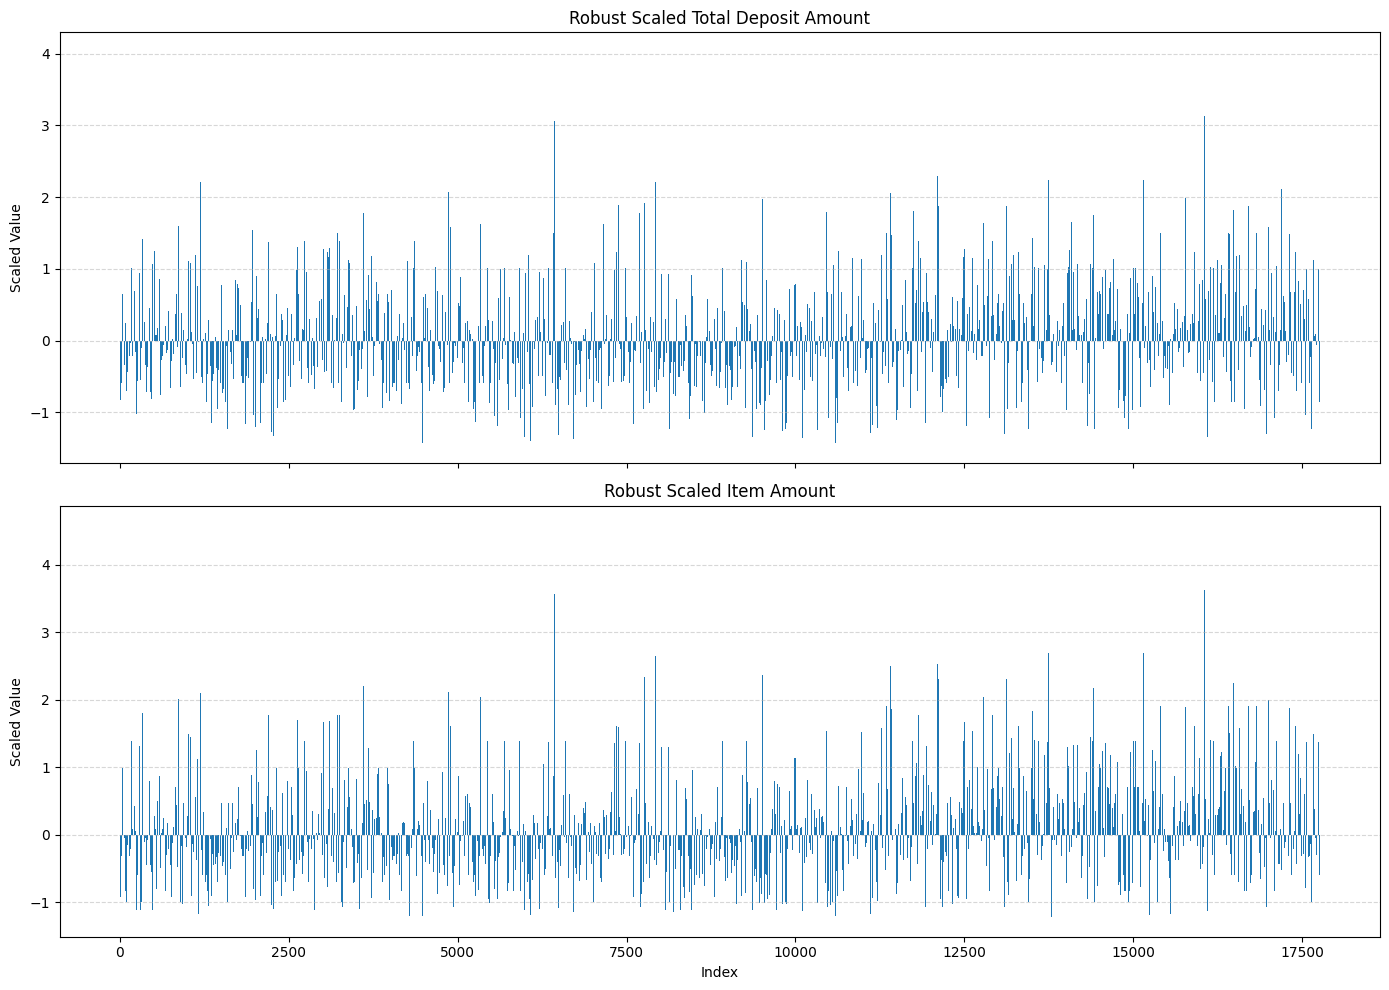

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# total_deposit_amount
axes[0].bar(df_final.index, df_final['robust_scaler__total_deposit_amount'])
axes[0].set_title('Robust Scaled Total Deposit Amount')
axes[0].set_ylabel('Scaled Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# item_amt
axes[1].bar(df_final.index, df_final['robust_scaler__item_amt'])
axes[1].set_title('Robust Scaled Item Amount')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Scaled Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek
print(df['deposit_dayofweek'].value_counts().sort_index())


deposit_dayofweek
0    4907
1    3367
2    2801
3    2692
4    3998
Name: count, dtype: int64


In [12]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_final.head(5)

,cat__onus_ind_F,cat__onus_ind_T,cat__treasury_check_ind_N,cat__treasury_check_ind_Y,cat__heloc_ind_N,cat__heloc_ind_Y,cat__masked_bank_num_0,cat__masked_bank_num_1,cat__masked_bank_num_2,cat__masked_bank_num_3,cat__masked_bank_num_4,cat__masked_bank_num_5,cat__masked_bank_num_6,cat__masked_bank_num_7,cat__masked_account_type_0,cat__masked_account_type_1,cat__masked_account_type_2,cat__masked_account_type_3,cat__masked_account_type_4,cat__masked_product_code_grouped_Other,cat__masked_product_code_grouped_prod_0,cat__masked_product_code_grouped_prod_1,cat__masked_product_code_grouped_prod_2,cat__masked_product_code_grouped_prod_4,cat__masked_product_code_grouped_prod_5,cat__masked_product_code_grouped_prod_6,cat__masked_product_code_grouped_prod_7,cat__masked_product_code_grouped_prod_9,cat__relationship_balance_new_account_0,cat__relationship_balance_new_account_1,cat__oao_flg_0,cat__oao_flg_1,cat__deposit_dayofweek_0,cat__deposit_dayofweek_1,cat__deposit_dayofweek_2,cat__deposit_dayofweek_3,cat__deposit_dayofweek_4,cat__deposit_quarter_1,cat__deposit_quarter_2,cat__deposit_quarter_3,cat__deposit_quarter_4,log_num__rdis,log_num__max_deposit_amount30d,log_num__total_deposit_item_count,num__drawee_sum,num__drawee_cnt,robust_scaler__total_deposit_amount,robust_scaler__item_amt,robust_scaler__prevtran1,robust_scaler__prevtran2,robust_scaler__prevtran3,robust_scaler__prevtran4,robust_scaler__prevtran5,robust_scaler__prevtran6,robust_scaler__prevtran_mean,robust_scaler__prevtran_std,robust_scaler__prevtran_sum,robust_scaler__prevtran_diff0,robust_scaler__prevtran_ratio0,robust_scaler__prevtran_diff1,robust_scaler__prevtran_ratio1,robust_scaler__acf_lag1,robust_scaler__rolling_mean_prevtran_3,robust_scaler__rolling_mean_prevtran_5,robust_scaler__rolling_std_prevtran_3,robust_scaler__rolling_std_prevtran_5,standard_scaler__prevtrandate1,standard_scaler__prevtrandate2,standard_scaler__prevtrandate3,standard_scaler__relationship_balance,standard_scaler__drawee_sum,standard_scaler__drawee_cnt,standard_scaler__rdis,standard_scaler__max_deposit_amount30d,standard_scaler__total_deposit_item_count,standard_scaler__prevtrandate_mean,standard_scaler__prevtrandate_std,standard_scaler__num_trans_in_1d,standard_scaler__num_trans_in_5d,standard_scaler__num_trans_in_10d,standard_scaler__rel_balance_ratio,standard_scaler__rel_balance_signed_log,standard_scaler__max_dep_ratio_30d,remainder__bucket_days_since_open,remainder__number_of_owners,remainder__prevtrandate4,remainder__prevtrandate5,remainder__prevtrandate6,remainder__return_target,remainder__month_num,remainder__prevtran_valid_count,remainder__isoutlier_prevtran
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.090366,0.000000,0.090942,1.687778,-0.567392,-0.291961,-0.012043,0.079112,0.155428,0.952124,0.929227,1.013793,-0.308453,-0.269239,0.233927,-0.204263,-0.153948,-0.052190,-0.007806,-1.242088e+00,0.047564,0.039506,0.057926,0.094165,-0.212997,-0.416560,-0.289704,-0.002708,0.090942,1.687778,-0.154624,-0.073522,-0.191445,-0.369609,-0.471110,-1.043324,-1.007564,-0.170679,-0.036405,1.205782,-0.078009,3.0,1.0,30.0,30.0,37.0,0.0,8.0,10.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,-0.277019,0.000000,-0.127813,0.128931,-1.226600,-0.992730,-0.346762,-0.042292,-0.749734,0.000000,0.000000,0.000000,-0.489885,-0.324811,-0.271461,-0.293443,-0.233582,0.000000,-0.000028,8.160893e-01,-0.069390,-0.073963,-0.036130,-0.131569,1.540272,1.107629,0.805598,-0.010494,-0.127813,0.128931,-0.154624,-0.096933,-0.191445,0.398695,-1.037459,-1.043324,-1.007564,-1.073227,-0.036373,-1.161578,-0.116527,0.0,1.0,71.0,71.0,71.0,0.0,4.0,2.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 92 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   cat__onus_ind_F                            17765 non-null  float64
 1   cat__onus_ind_T                            17765 non-null  float64
 2   cat__treasury_check_ind_N                  17765 non-null  float64
 3   cat__treasury_check_ind_Y                  17765 non-null  float64
 4   cat__heloc_ind_N                           17765 non-null  float64
 5   cat__heloc_ind_Y                           17765 non-null  float64
 6   cat__masked_bank_num_0                     17765 non-null  float64
 7   cat__masked_bank_num_1                     17765 non-null  float64
 8   cat__masked_bank_num_2                     17765 non-null  float64
 9   cat__masked_bank_num_3                     17765 non-null  float64
 10  cat__masked_bank_num_4